# Video inference position and distance estimation

Using the od of our model on a new image and a simple projective model

In [1]:
from video_utils import *

## 1. Select a model for inference using the CenterNet object detector model 

In [2]:
import tensorflow as tf
import larq as lq

We will use the arguments from the inference file as defined in the project readme

In [3]:
args =  ['--architecture', 'resnet50_centernet', '--gpu', '6', '--dataset-path', '../../datasets/PascalVOC/', '--model-weights-path', 'saved_models/resnet50_centernet/resnet50_centernet_model.h5']
# on the inference script we use: args = sys.argv[1:]
args = infer.parse_args(args)

{'architecture': 'resnet50_centernet', 'batch_size': 32, 'num_classes': 20, 'input_size': 512, 'gpu': '6', 'model_summary': True, 'dataset_path': '../../datasets/PascalVOC/', 'model_weights_path': 'saved_models/resnet50_centernet/resnet50_centernet_model.h5'}


Now we get the parsed args

In [4]:
num_classes = args.num_classes
input_size = (args.input_size,args.input_size)
#assert input_size[0] == input_size[1], "Input shape must be the same"
batch_size = args.batch_size
# optionally choose specific GPU
if args.gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
# CHECK GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print('problem loading gpu')
import importlib
sys.path.append('architectures')
#import architecture module
architecture_module = importlib.import_module(args.architecture)

# set architecture name
architecture_name = args.architecture

Default GPU Device: /device:GPU:0


Instantiate a model, download weights and compile

In [5]:
# create model given an architecture
# (the centernet input must be specified by the architecture file)
model, prediction_model, debug_model = architecture_module.centernet(input_size = input_size, num_classes = num_classes)

try:
    model.load_weights(args.model_weights_path)
    print("Model loaded!")
except:
    print("Error: Failed loading model from weights...")
    #sys.exit(1)

# compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss={'centernet_loss': lambda y_true, y_pred: y_pred})

# change to True to print model summary
if False:
    lq.models.summary(model)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model loaded!


Open the validation dataset and instantiate a generator

## 2. Video frame processing


### 2.1. Get .mp4 files

Note that this depends on the data location. 

In [6]:
video_path = os.path.join('..','..','datasets','NokiaVillarceauxVideoFeed')
video_path

'../../datasets/NokiaVillarceauxVideoFeed'

In [7]:
!ls '../../datasets/NokiaVillarceauxVideoFeed'

BOU	     chessboard.png  GAL-EXT-NORD-OUEST_2022-06-01_08h44min22s120ms.mp4
CALIBRATION  GAL


In [8]:
filenames = []
dirnames = []
for (_dirpath, _dirnames, _filenames) in os.walk(video_path):
    filenames.extend(_filenames)
    dirnames.extend(_dirnames)
    break

In [9]:
filepath = os.path.join(video_path, filenames[1])
filepath

'../../datasets/NokiaVillarceauxVideoFeed/GAL-EXT-NORD-OUEST_2022-06-01_08h44min22s120ms.mp4'

### 2.2 Processing footage

timestamp; fps; nframes

nframes/fps = dt

timestamp/dt = framestamp

Video width: 1920, video height = 1080
Video length in frames: 17316, video fps rate = 14.972115343046129 [s^-1], play time = 1156.55 [ms]
0.06679082929082929
Frame Found: frame = 1003 , time captured = 66.99 [ms]


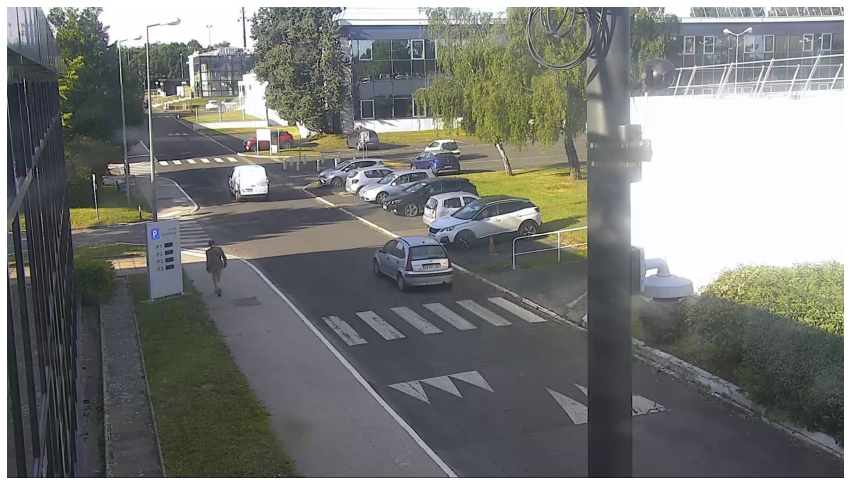

In [10]:
test_img = get_frame_time(filepath, time_of_interest = 67, plot_img = True, verbose = 1)

## 2.3 Object detection on video 

Video width: 1920, video heigth = 1080
Read a new frame: True, frame = 0 , iteration = 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Inference time :  3.6051039695739746


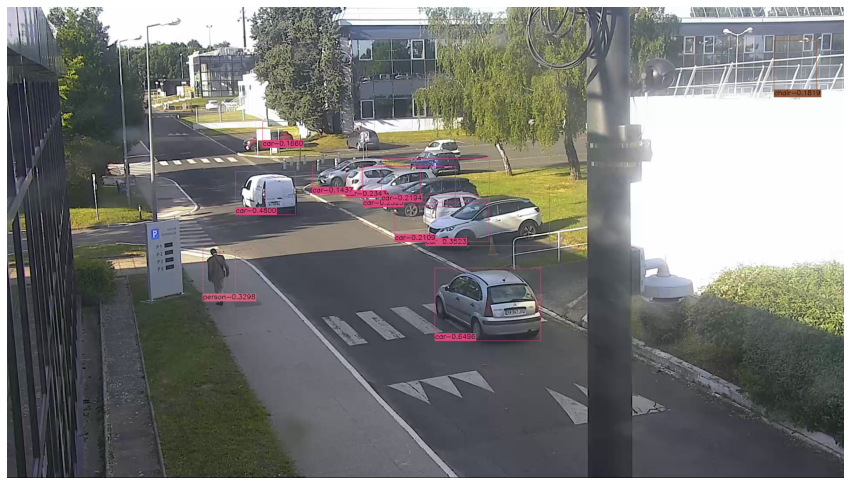

Read a new frame: True, frame = 1000 , iteration = 1
Inference time :  0.0402073860168457


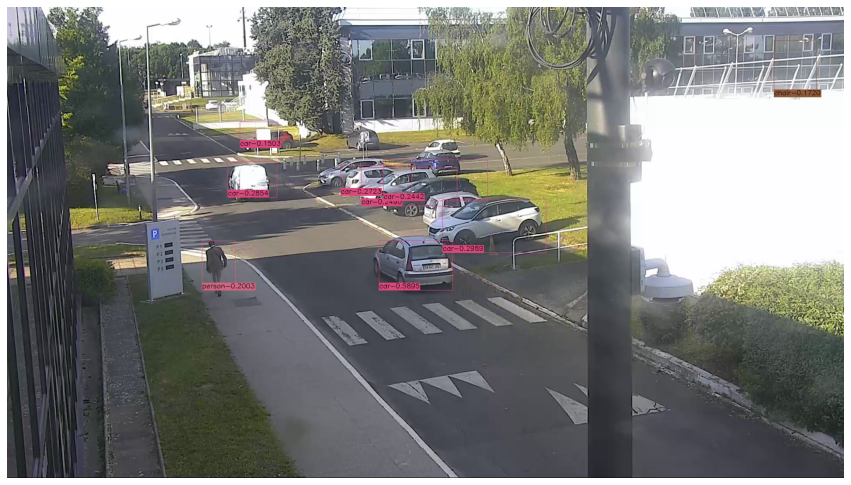

Read a new frame: True, frame = 2000 , iteration = 2
Inference time :  0.032926321029663086


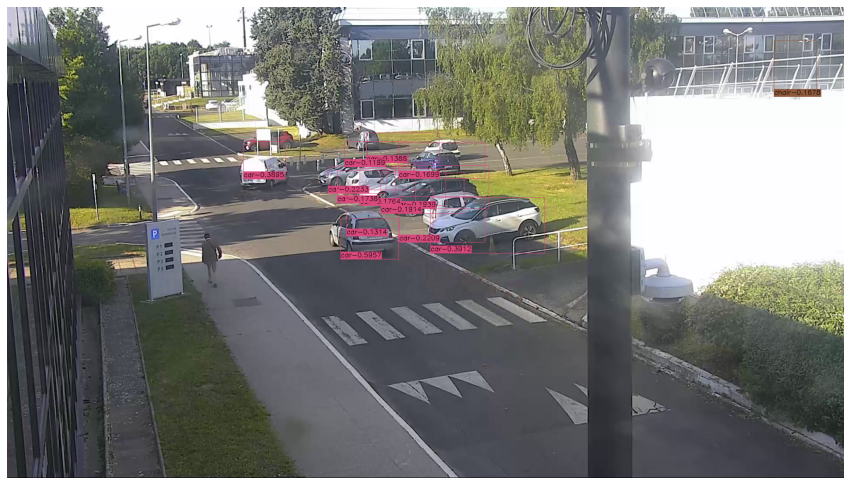

In [11]:
preds0 = video_od(prediction_model, filepath, max_it = 3, plot_img = True, figsize = (15,15), speed = 1000, verbose = 1)

# To make a correspondence between cam coordinates and world coordinates we need to associate image points with the world map. 

We obtain them in the ground-truth extraction notebook. 

Here we justuse the ground truth

In [12]:
height_res = 1080
width_res = 1920

gt_pixel_coords = []
# first gt polar coord is the camera center
gt_pixel_coords.append([int(height_res/2),(int(width_res/2))])
gt_pixel_coords.append([580,550])
gt_pixel_coords.append([600,1150])
gt_pixel_coords.append([740,1310])
gt_pixel_coords.append([820,1180])

The ground truth in cartesian coordinates corresponds to the world coordinates with fixed referencial on the camera.

We use the referential of the documentation [*To do: add to doc*] (X,Y,Z)

Note that we set the camera at (0 , 0, 0) in our calibration such that the gt coords are are negative on the first coordinate.

In [13]:
gt_cartesian_measures = []
# first gt cartesian coord 0 is corresponds to point in plane that is projected to camera center
gt_cartesian_measures.append([-5, 0.0, 39.0, ])
gt_cartesian_measures.append([-5,  -5.797591707765803,32.87977644981859])
gt_cartesian_measures.append([-5, 4.29036190549212,28.0376406054415])
gt_cartesian_measures.append([-5, 4.846548482564238,24.933330459570662 ])
gt_cartesian_measures.append([-5, 2.676372496881757,20.606926754320618 ])

Let's plot the image with the ground truth

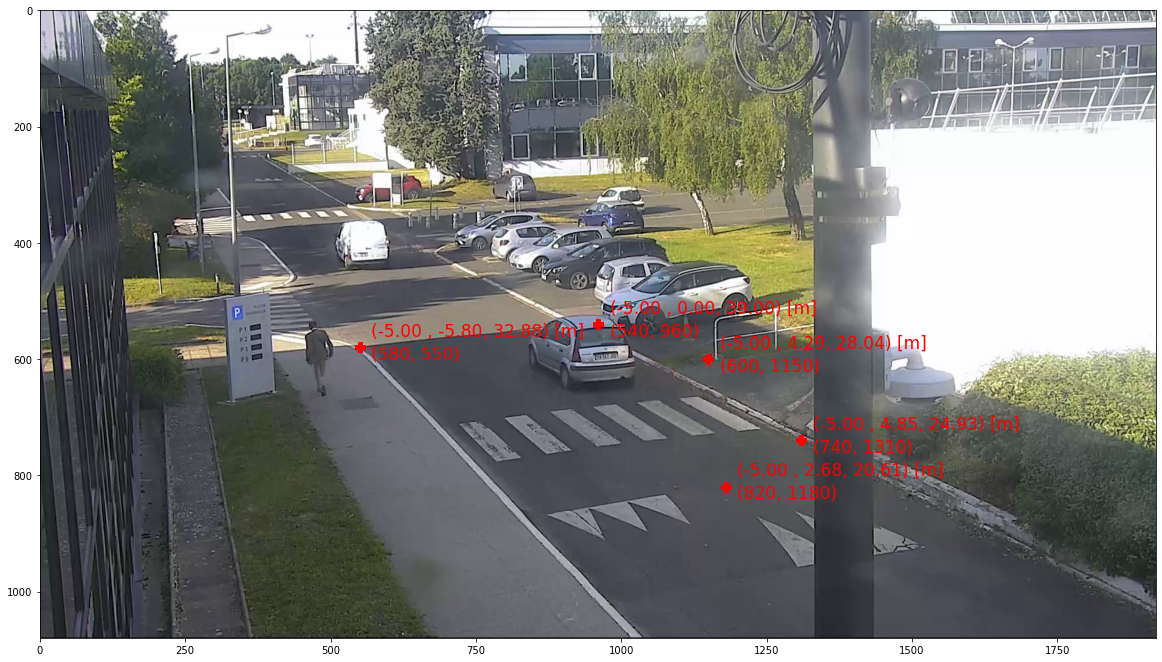

In [14]:
alfa = 20
plt.figure(figsize=(20,20))
plt.imshow(test_img)

# plot pixel and cartesian coordinates
for pixel_coord, cart_coord in zip(gt_pixel_coords, gt_cartesian_measures):
    label_pixel_coord = str((pixel_coord[0],pixel_coord[1]))
    label_cart_coord = '({:.2f} , {:.2f}, {:.2f}) [m]'.format(cart_coord[0],cart_coord[1],cart_coord[2])

    plt.plot(pixel_coord[1], pixel_coord[0], 'P', c = 'r', markersize = '10')
    plt.text(pixel_coord[1]+alfa, pixel_coord[0]+alfa, label_pixel_coord, c = 'r', fontsize = 17)
    plt.text(pixel_coord[1]+alfa, pixel_coord[0]-alfa, label_cart_coord, c = 'r', fontsize = 17)


plt.axis('on')
plt.show()

# 2.4 Object Detection on a specific frame

Our algorithm will extract the bounding boxes and the heatmap containing a mixture of gaussians from the image. Currently, all processing is done on a 512x512 px images.

We only look for the class 'person' and 'car'

to change displayed classes add the corresponding class index to the display_classes argument


* 'aeroplane': 0,
* 'bicycle': 1,
* 'bird': 2,
* 'boat': 3,
* 'bottle': 4,
* 'bus': 5,
* 'car': 6,
* 'cat': 7,
* 'chair': 8,
* 'cow': 9,
* 'diningtable': 10,
* 'dog': 11,
* 'horse': 12,
* 'motorbike': 13,
* 'person': 14,
* 'pottedplant': 15,
* 'sheep': 16,
* 'sofa': 17,
* 'train': 18,
* 'tvmonitor': 19


In [15]:
pred_filtered = analyse_prediction(preds0[1], verbose = 2, img_dimensions = (1920,1080), 
                                   display_classes = [6,14], ul_lim = (445,0), lr_lim = None)

****
Object:car
Confidence 0.58954256772995 
Upper left: (852.9574012756348 534.9232292175293)
Lower right: (1022.0417404174805 648.6096954345703)
****
Object:person
Confidence 0.20032045245170593 
Upper left: (447.2174263000488 535.7306671142578)
Lower right: (524.479808807373 649.2704772949219)
******
Found 1 objects from class car
Found 1 objects from class person


In [16]:
car_predictions = [p for p in pred_filtered if p[-1] == 6]
car_predictions

[array([8.52957401e+02, 5.34923229e+02, 1.02204174e+03, 6.48609695e+02,
        5.89542568e-01, 6.00000000e+00])]

In [17]:
ppl_predictions = [p for p in pred_filtered if p[-1] == 14]
ppl_predictions

[array([4.47217426e+02, 5.35730667e+02, 5.24479809e+02, 6.49270477e+02,
        2.00320452e-01, 1.40000000e+01])]

### Display center of object and bouding box definition

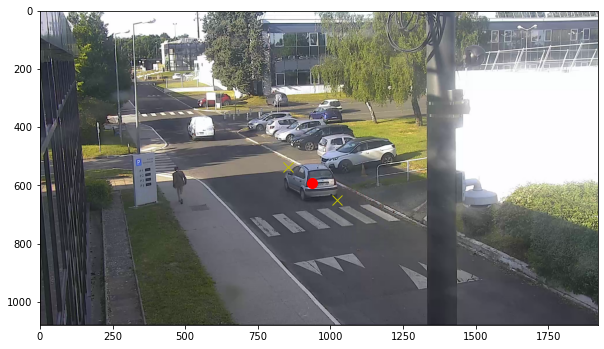

In [18]:
plot_object_center(test_img,car_predictions[0])

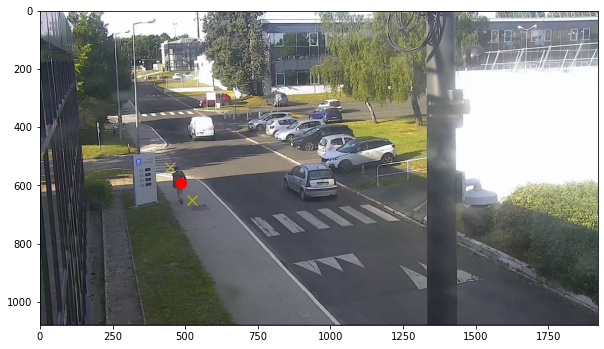

In [19]:
plot_object_center(test_img,ppl_predictions[0])

## 3. Position estimation based on Camera Model and Object Detection

# Cam params

**Lens** 4.44-142.6 mm, F1.6-4.41

**Horizontal angle of view:** 62.8˚- 2.23˚

**Vertical angle of view:** 36.8˚- 1.3˚

**Camera world position:** Needs validation but for now we set it as (0,0)

**Camera tilt and camera altitude:** Should be determined experimentally either by callibration or preferably by measures on the ground

## 3.1 Results


#### Validating results: projecting points on image


In [20]:
# person example ground truth
person_gt = [-5, -5.209267685839688, 32.89002174181808]

# polar to cartesian: (r,/_alpha) in degrees to (x,y) in cartesian
CAM_CENTER_REF_GT_ANGLE = 229 # In degrees
_cart = lambda _r, _alpha : (np.cos(math.radians(_alpha - CAM_CENTER_REF_GT_ANGLE))*_r, np.sin(math.radians(_alpha - CAM_CENTER_REF_GT_ANGLE))*_r)

_pixel_pos = get_bb_center(ppl_predictions[0])
estimation = get_object_pos(_pixel_pos)

print('pixel coordinates = {}'.format(_pixel_pos))
print('ground truth = ({}, {}) [m]'.format(person_gt[2], person_gt[1]))
print('estimation = {} [m]'.format(estimation))

pixel coordinates = (485.84861755371094, 592.5005722045898)
ground truth = (32.89002174181808, -5.209267685839688) [m]
estimation = (33.68811074789643, -9.027890889149354) [m]


In [21]:
# car ground truth
car_gt = [-5, -1.88, 35.95]


_pixel_pos = get_bb_center(car_predictions[0])
estimation = get_object_pos(_pixel_pos)

print('pixel coordinates = {}'.format(_pixel_pos))
print('ground truth = ({}, {})'.format(car_gt[2], car_gt[1]))
print('estimation = {}'.format(estimation))

pixel coordinates = (937.4995708465576, 591.7664623260498)
ground truth = (35.95, -1.88)
estimation = (33.74720350191889, -0.429161956200518)


#### Using ground truth points

Obs.: Note that the ground truth points assume the same height with respect to the camera, a condition that may not be true

In [22]:
coords_estimation = [get_object_pos([px_coords[1],px_coords[0]], camera_tilt = W) for px_coords in gt_pixel_coords]
for idx, (pixel, gt) in enumerate(zip(gt_pixel_coords, gt_cartesian_measures)):
    print('TEST {}:'.format(idx))
    print('pixel coordinates = {} '.format(pixel))
    print('ground truth = ({}, {}) [m]'.format(gt[2], gt[1]))
    print('estimation = {} [m]'.format(coords_estimation[idx]))
    print('#########################')

TEST 0:
pixel coordinates = [540, 960] 
ground truth = (39.0, 0.0) [m]
estimation = (38.49786750224376, 0.0) [m]
#########################
TEST 1:
pixel coordinates = [580, 550] 
ground truth = (32.87977644981859, -5.797591707765803) [m]
estimation = (34.72289727668217, -8.046229886970043) [m]
#########################
TEST 2:
pixel coordinates = [600, 1150] 
ground truth = (28.0376406054415, 4.29036190549212) [m]
estimation = (33.095869531305645, 3.5540212573784746) [m]
#########################
TEST 3:
pixel coordinates = [740, 1310] 
ground truth = (24.933330459570662, 4.846548482564238) [m]
estimation = (24.876897597034887, 4.9210399086286705) [m]
#########################
TEST 4:
pixel coordinates = [820, 1180] 
ground truth = (20.606926754320618, 2.676372496881757) [m]
estimation = (21.758272252914193, 2.7054512438968823) [m]
#########################


## 4. Speed estimation Proof of concept

#### Frame extraction spaced by delta_t





In [31]:
delta_t = 10 # check units 

Video width: 1920, video height = 1080
Video length in frames: 17316, video fps rate = 14.972115343046129 [s^-1], play time = 1156.55 [ms]
0.06679082929082929
Frame Found: frame = 748 , time captured = 49.96 [ms]


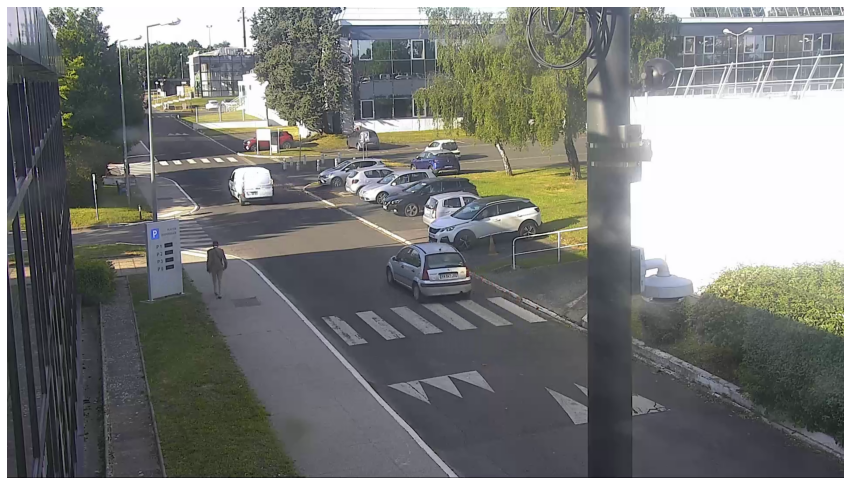

In [123]:
test_img_1 = get_frame_time(filepath, time_of_interest = 50, plot_img = True, verbose = 1)

Video width: 1920, video height = 1080
Video length in frames: 17316, video fps rate = 14.972115343046129 [s^-1], play time = 1156.55 [ms]
0.06679082929082929
Frame Found: frame = 898 , time captured = 59.98 [ms]


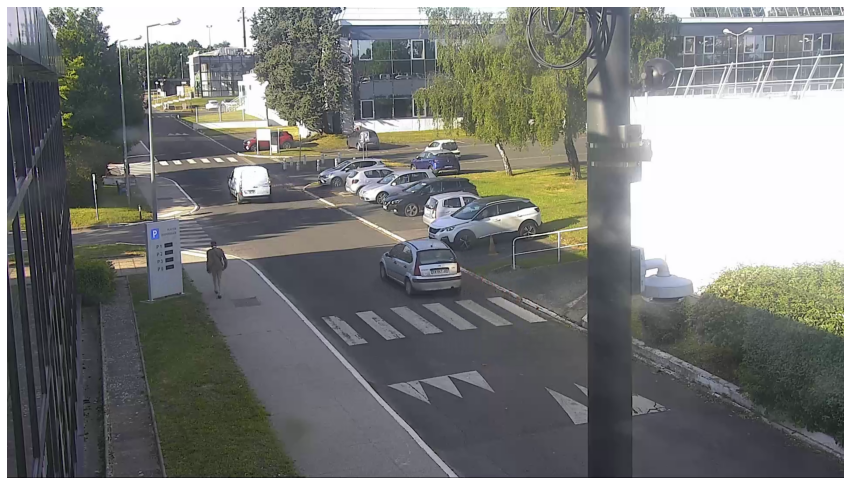

In [124]:
test_img_2 = get_frame_time(filepath, time_of_interest = 50+delta_t, plot_img = True, verbose = 1)

Video width: 1920, video height = 1080
Video length in frames: 17316, video fps rate = 14.972115343046129 [s^-1], play time = 1156.55 [ms]
0.06679082929082929
Frame Found: frame = 1048 , time captured = 70.00 [ms]


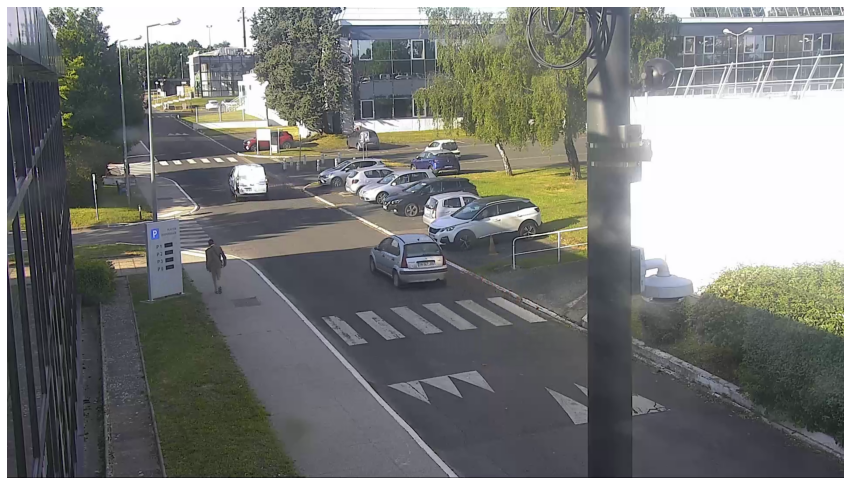

In [125]:
test_img_3 = get_frame_time(filepath, time_of_interest = 50+2*delta_t, plot_img = True, verbose = 1)

In [126]:
# OD on different 2 frames blocks
def speed_inference(images, delta_t, pred_model, classes = voc_classes,  
             plot_img = False , figsize = (15,15), colors = None, verbose = 0):
    """
    print or save video frames as images using cv2.
    :images: list of images
    :delta_t:
    :pred_model: object detection model
    :path_in: video file path
    :classes: dict of classes used by the model to predict
    :max_it: describe about parameter p3
    :plot_img: set to True to plot image with matplotlib
    :speed: set speed for reading frames (eg.: speed = 10 reads an image for each 10 frames)
    :pathOut: describe about parameter p2
    :figsize: set figsize for matplotlib imshow
    :colors: set colors according to classes
    :verbose: disable to silence function prints
    :return: list of predictions for each frame
    """ 
        
    if colors is None:
        colors = [np.random.randint(0, 256, 3).tolist() for i in range(len(classes))]
    
    predictions = []
    
    for img in images:  
        predictions.append(image_direct_inference(img, pred_model, colors, verbose = verbose, plot_img = plot_img, figsize = figsize))
    
    
        
    return predictions

In [127]:
predictions = speed_inference([test_img_1, test_img_2, test_img_3], delta_t, prediction_model)

### Let's predict a single car speed. We have to extract it from the object detection predictions

Obs: We isolate a single car by trimming positions according to the image position

In [128]:
pred_filtered_1 = analyse_prediction(predictions[0], verbose = 2, img_dimensions = (1920,1080), 
                                   display_classes = [6], ul_lim = (445,0), lr_lim = None)
center_pixel_pos_1 = get_bb_center(pred_filtered_1[0])


****
Object:car
Confidence 0.2880234718322754 
Upper left: (884.6342468261719 547.6468276977539)
Lower right: (1050.3648376464844 666.082649230957)
****
Object:car
Confidence 0.12636278569698334 
Upper left: (1015.0112915039062 446.2240219116211)
Lower right: (1249.419937133789 557.5112915039062)
******
Found 2 objects from class car


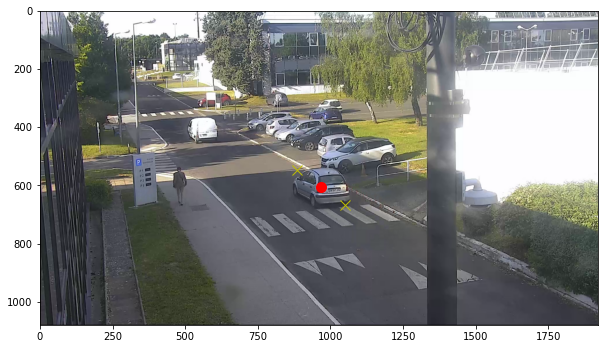

In [129]:
plot_object_center(test_img_1,pred_filtered_1[0])

In [130]:
pred_filtered_2 = analyse_prediction(predictions[1], verbose = 2, img_dimensions = (1920,1080), 
                                   display_classes = [6], ul_lim = (445,0), lr_lim = None)
center_pixel_pos_2 = get_bb_center(pred_filtered_2[0])

****
Object:car
Confidence 0.3983609080314636 
Upper left: (877.7798080444336 543.9662933349609)
Lower right: (1027.2189331054688 641.0341644287109)
****
Object:car
Confidence 0.12923474609851837 
Upper left: (1013.0730056762695 448.5017967224121)
Lower right: (1251.9258499145508 556.1226654052734)
******
Found 2 objects from class car


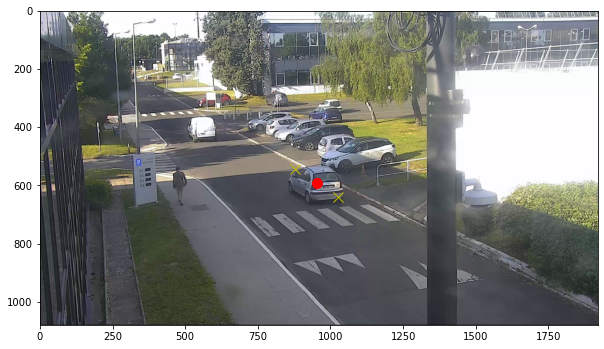

In [131]:
plot_object_center(test_img_2,pred_filtered_2[0])

In [132]:
pred_filtered_3 = analyse_prediction(predictions[2], verbose = 2, img_dimensions = (1920,1080), 
                                   display_classes = [6], ul_lim = (445,0), lr_lim = None)
center_pixel_pos_3 = get_bb_center(pred_filtered_3[0])

****
Object:car
Confidence 0.47286584973335266 
Upper left: (836.425666809082 520.1592636108398)
Lower right: (1007.7084732055664 634.841423034668)
******
Found 1 objects from class car


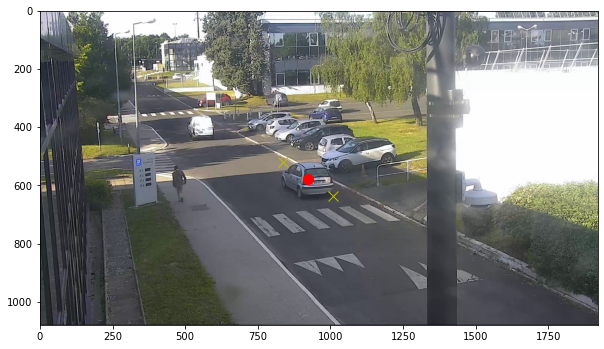

In [133]:
plot_object_center(test_img_3,pred_filtered_3[0])

### Now obtain the car position using the position inference

In [134]:
def speed_estimation(center_px_1, center_px_2, delta_t):
    estimation_1 = get_object_pos(center_px_1)
    estimation_2 = get_object_pos(center_px_2)
    
    delta_z = (estimation_2[0] - estimation_1[0])
    delta_y = (estimation_2[1] - estimation_1[1])
    
    speed_zy = [delta_z/delta_t, delta_y/delta_t]
    
    return np.linalg.norm(speed_zy, ord = 2), speed_zy

#####  Between frame 1 and 2

In [232]:
vector_speed = speed_estimation(center_pixel_pos_1, center_pixel_pos_2, delta_t*20)
print("Absolute inferred speed is {:.2f} [Km/h]".format(vector_speed[0]*1000*3.6))
print("inferred speed direction is ({:.2f},{:.2f}) [Km/h]".format(vector_speed[1][0]*1000*3.6, vector_speed[1][1]*1000*3.6))

Absolute inferred speed is 20.73 [Km/h]
inferred speed direction is (20.10,-5.06) [Km/h]


#####  Between frame 2 and 3

In [233]:
vector_speed = speed_estimation(center_pixel_pos_2, center_pixel_pos_3, delta_t*20)
print("Absolute inferred speed is {:.2f} [Km/h]".format(vector_speed[0]*1000*3.6))
print("inferred speed direction is ({:.2f},{:.2f}) [Km/h]".format(vector_speed[1][0]*1000*3.6, vector_speed[1][1]*1000*3.6))

Absolute inferred speed is 24.99 [Km/h]
inferred speed direction is (22.49,-10.91) [Km/h]


#####  Between frame 1 and 3

In [234]:
vector_speed = speed_estimation(center_pixel_pos_1, center_pixel_pos_3, 2*delta_t*20)
print("Absolute inferred speed is {:.2f} [Km/h]".format(vector_speed[0]*1000*3.6))
print("inferred speed direction is ({:.2f},{:.2f}) [Km/h]".format(vector_speed[1][0]*1000*3.6, vector_speed[1][1]*1000*3.6))

Absolute inferred speed is 22.74 [Km/h]
inferred speed direction is (21.29,-7.98) [Km/h]


## 5. Plot Speed Inference given the last prediction

Note the best approximation would be to use a Kalman filter, but we leave this as a next implementation.

In [217]:
# OD on different frames blocks
def video_speed_pos_inference(pred_model, path_in, classes = voc_classes, max_it = 5, speed = 1, 
             plot_img = False , figsize = (15,15), colors = None, verbose = 0):
    """
    print or save video frames as images using cv2.
    :pred_model: object detection model
    :path_in: video file path
    :classes: dict of classes used by the model to predict
    :max_it: describe about parameter p3
    :plot_img: set to True to plot image with matplotlib
    :speed: set speed for reading frames (eg.: speed = 10 reads an image for each 10 frames)
    :pathOut: describe about parameter p2
    :figsize: set figsize for matplotlib imshow
    :colors: set colors according to classes
    :verbose: disable to silence function prints
    :return: list of predictions for each frame
    """ 
    
    
    if colors is None:
        colors = [np.random.randint(0, 256, 3).tolist() for i in range(len(classes))]
    
    predictions = []
    positions = [] 
    times = []
    speeds = []
    
    
    count = 0
    vidcap = cv2.VideoCapture(path_in)
    
    if verbose > 0:
         # Convert the resolutions from float to integer.
        frame_width = int(vidcap.get(3))
        frame_height = int(vidcap.get(4))
        print ('Video width: {}, video heigth = {}'.format(frame_width, frame_height))
    
    success,image = vidcap.read()
    success = True
    
    while success:
            
        time = count*speed
        times.append(time)
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(time))    # added this line 
        success,image = vidcap.read()
        if verbose > 0:
            print ('Read a new frame: {}, time = {} [ms] , iteration = {}'.format(success, time, count))
        
        src_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        pred = image_direct_inference(image, pred_model, colors, verbose = verbose, plot_img = False, figsize = figsize)
        
        
        # filter preds
        filt_pred = analyse_prediction(pred, verbose = 0, img_dimensions = (1920,1080), 
                                   display_classes = [6], ul_lim = (445,0), lr_lim = None)
        predictions.append(filt_pred)
        
        # hopefully only only one car is present
        center_pixel_pos = get_bb_center(filt_pred[0])
        
        # obtain position of center in world coordinates
        world_pos_estimation = get_object_pos(center_pixel_pos)
        positions.append(world_pos_estimation)
        
        # calculate speed wrp to previous frame
        if count > 0:
            delta_t = times[count] - times[count-1]
            delta_z = (positions[count][0] - positions[count-1][0])
            delta_y = (positions[count][1] - positions[count-1][1])
            speed_zy = [delta_z/delta_t*1000*3.6, delta_y/delta_t*1000*3.6]
            speeds.append([np.linalg.norm(speed_zy,ord = 2), speed_zy])
        else:
            speeds.append([0,[0,0]])

        # should have made at least one pred
        
        count = count + 1
        if count >= max_it:
            break
        
    return predictions, positions, speeds

In [218]:
preds_car, positions_car, speeds_car = video_speed_pos_inference(prediction_model, filepath, max_it = 5, plot_img = True, figsize = (15,15), speed = 500, verbose = 1)

Video width: 1920, video heigth = 1080
Read a new frame: True, time = 0 [ms] , iteration = 0
Inference time :  0.03268837928771973
Read a new frame: True, time = 500 [ms] , iteration = 1
Inference time :  0.03728055953979492
Read a new frame: True, time = 1000 [ms] , iteration = 2
Inference time :  0.033670663833618164
Read a new frame: True, time = 1500 [ms] , iteration = 3
Inference time :  0.0333859920501709
Read a new frame: True, time = 2000 [ms] , iteration = 4
Inference time :  0.03342413902282715


In [235]:
preds_car

[[array([9.81416245e+02, 5.97759361e+02, 1.22358307e+03, 7.65392189e+02,
         6.49610817e-01, 6.00000000e+00])],
 [array([9.22727737e+02, 5.62832336e+02, 1.10227135e+03, 7.10821838e+02,
         5.31170785e-01, 6.00000000e+00])],
 [array([8.52957401e+02, 5.34923229e+02, 1.02204174e+03, 6.48609581e+02,
         5.89542568e-01, 6.00000000e+00])],
 [array([8.11950073e+02, 5.05576744e+02, 9.70520782e+02, 6.15565453e+02,
         6.06389165e-01, 6.00000000e+00])],
 [array([7.65376797e+02, 4.84641380e+02, 8.97538891e+02, 5.78038445e+02,
         5.95721245e-01, 6.00000000e+00])]]

In [219]:
positions_car

[(27.764965869064955, 2.236163664039685),
 (30.460913153802675, 0.9038389635182629),
 (33.74720811585217, -0.42916201487573924),
 (36.46108617553074, -1.417055863922773),
 (39.42377222540584, -2.864154108880924)]

In [220]:
speeds_car

[[0, [0, 0]],
 [21.651802924594172, [19.410820450111583, -9.59273784375424]],
 [25.53374828500089, [23.661323726756347, -9.597607044436815]],
 [20.79425364874386, [19.53992202968571, -7.112835713138643]],
 [23.739920927457536, [21.33133955910074, -10.419107363698686]]]